In [2]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

import PIL
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset
# from galaxy_mnist import GalaxyMNIST

from torchvision.datasets import ImageFolder

import torch.nn.functional as TF

from torchvision.transforms import transforms
from torch.utils.data import TensorDataset

import cv2
import torchvision.models as models

In [3]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%pip install git+https://github.com/mwalmsley/galaxy_mnist.git
from galaxy_mnist import GalaxyMNIST


  Cloning https://github.com/mwalmsley/galaxy_mnist.git to /tmp/pip-req-build-mlmlpwks
  Running command git clone --filter=blob:none --quiet https://github.com/mwalmsley/galaxy_mnist.git /tmp/pip-req-build-mlmlpwks
  Resolved https://github.com/mwalmsley/galaxy_mnist.git to commit 375e0257bfd41acbcb7ba2e0f33c8c04d0d5beef
  Preparing metadata (setup.py) ... done
  Created wheel for galaxyMNIST: filename=galaxyMNIST-0.1.0-py3-none-any.whl size=17121 sha256=8551dbb501f8b43a8d32a49cd5692a89ce30fd80a7b78ae0ce277b56644a6665
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgfm78zo/wheels/5d/66/ad/09ca7d27690e6034ba53ae72c03b6bd30aa5818dc3ffd58e79
Successfully built galaxyMNIST
Note: you may need to restart the kernel to use updated packages.


In [5]:
#  Import galaxyMNIST dataset
dataset = GalaxyMNIST(
    root='ML_DP/gal_mnist',
    download=True,
    train=False  # by default, or False for canonical test set
)

images = dataset.data
labels = dataset.targets

# Split in test, validation, train
images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

# Create PyTorch dataset
train_dataset = TensorDataset(images_train, y_train)
val_dataset = TensorDataset(images_val, y_val)
test_dataset = TensorDataset(images_test, y_test)

100%|██████████| 68681710/68681710 [00:03<00:00, 17832374.53it/s]


Extracting ML_DP/gal_mnist/GalaxyMNIST/raw/train_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNIST/raw


100%|██████████| 17251325/17251325 [00:02<00:00, 8458451.79it/s] 


Extracting ML_DP/gal_mnist/GalaxyMNIST/raw/test_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNIST/raw


In [6]:
VGG_model = models.resnet152(pretrained=True)

for name, param in VGG_model.named_parameters():
    param.requires_grad = True

# define out classifier
classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=4096),
   nn.ReLU(),
   nn.Linear(in_features=4096, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=4)
)

# replace model class classifier attribute:
VGG_model.classifier = classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 81.2MB/s] 


In [7]:
# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device,
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=5):
    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    
    lear_rate = []
    
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float()# reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images)  # forward
            outputs = TF.softmax(outputs)
            _, pred = torch.max(outputs.data, 1)
            
            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                
                outputs = model(images)
                outputs = TF.softmax(outputs)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                _, pred = torch.max(outputs.data, 1)
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        lear_rate.append(scheduler.get_last_lr())
#         optim.lr_scheduler.StepLR.print_lr(is_)
    test_acc = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            test_acc += (pred == labels).sum().item()
            
            lab_pred.extend(pred.cpu().numpy())
            labels = labels.data.cpu().numpy()
            lab_true.extend(labels)
    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')
    
    
    
    return history, lab_true, lab_pred, lear_rate

In [8]:
# Train the CNN model
hist, lab_true, lab_pred, lr = train_model(VGG_model, train_dataset, val_dataset, test_dataset, device, lr=0.0001, batch_size=64, epochs=40, l2=0.001
                   , patience=5)

Training Start:


/tmp/ipykernel_34/1506924927.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = TF.softmax(outputs)
/tmp/ipykernel_34/1506924927.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = TF.softmax(outputs)


Epoch:1 / 40, lr: 0.00010 train loss:6.83146, train acc: 0.08306, valid loss:6.90038, valid acc:0.01339
Epoch:2 / 40, lr: 0.00010 train loss:6.66135, train acc: 0.24836, valid loss:6.69703, valid acc:0.19196
Epoch:3 / 40, lr: 0.00010 train loss:6.45884, train acc: 0.45888, valid loss:6.39694, valid acc:0.45759
Epoch:4 / 40, lr: 0.00010 train loss:6.28740, train acc: 0.62253, valid loss:6.31456, valid acc:0.54464
Epoch:5 / 40, lr: 0.00005 train loss:6.28058, train acc: 0.62664, valid loss:6.30335, valid acc:0.54464
Epoch:6 / 40, lr: 0.00005 train loss:6.27941, train acc: 0.62171, valid loss:6.25055, valid acc:0.59152
Epoch:7 / 40, lr: 0.00005 train loss:6.23171, train acc: 0.67270, valid loss:6.22373, valid acc:0.61161
Epoch:8 / 40, lr: 0.00005 train loss:6.21846, train acc: 0.68174, valid loss:6.21865, valid acc:0.61161
Epoch:9 / 40, lr: 0.00005 train loss:6.21585, train acc: 0.68421, valid loss:6.21878, valid acc:0.61161
Epoch:10 / 40, lr: 0.00003 train loss:6.20855, train acc: 0.6916

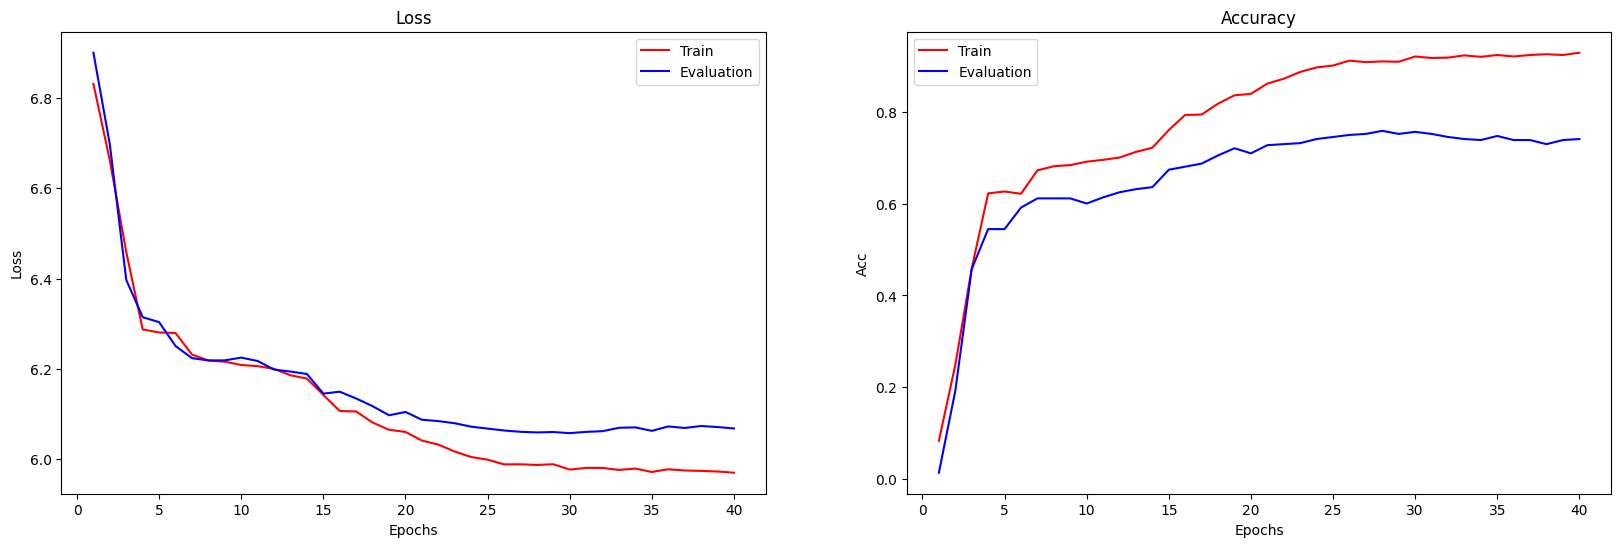

In [9]:
train_loss = torch.tensor(hist['train_loss'])
val_loss = torch.tensor(hist['val_loss'])
train_acc = torch.tensor(hist['train_acc'])
val_acc =  torch.tensor(hist['val_acc'])



# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, train_loss, 'r-', label='Train')
ax[0].plot(epochs, val_loss , 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, train_acc, 'r-', label='Train')
ax[1].plot(epochs, val_acc , 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

<Axes: >

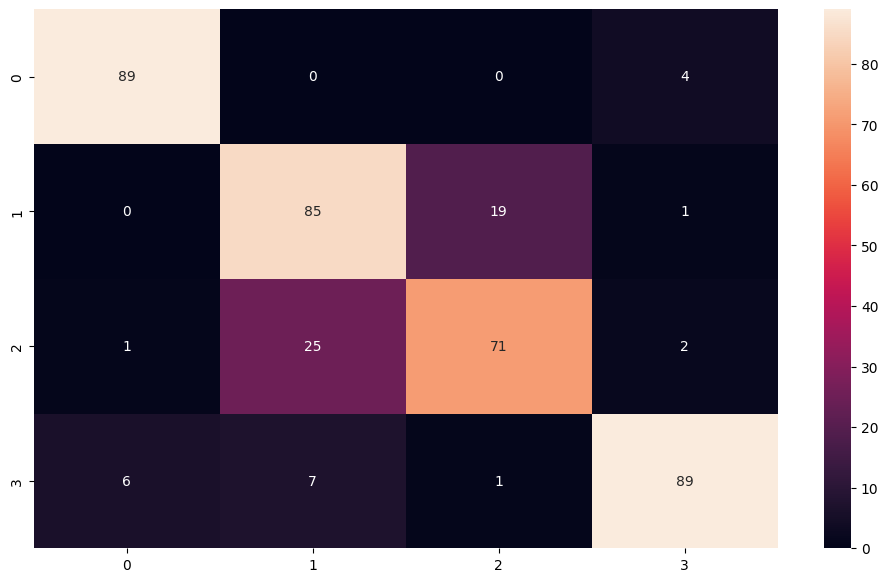

In [10]:
cf_matrix = confusion_matrix(lab_true, lab_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

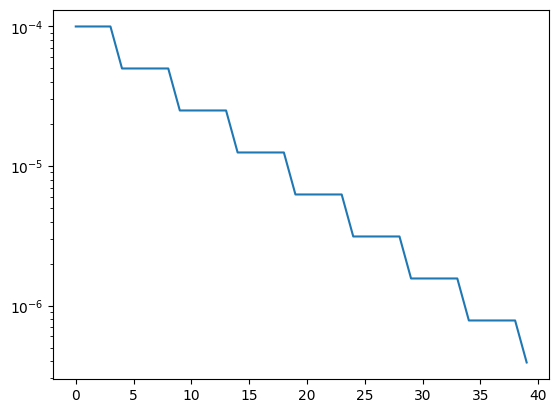

In [14]:
plt.plot(lr)
plt.yscale('log')

In [11]:
# batch norm, no pretrain, plot learning rate, vgg -> resnet, adam -> sgd